Part 2 - Q1 - Classic ML Methods
===

I am going to implement, with and without features engineering:

*  Logistic Regression
*  Random Forest

[xxx]

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tsfresh as tsf
from tsfresh import extract_features
import warnings

In [25]:
%matplotlib inline
import torch
import torch.nn.functional as F

In [26]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [27]:
import param
import panel as pn
pn.extension()
import datetime as dt
import importlib
from importlib import reload
from tqdm import tqdm

In [28]:
import graph as gr
import params as par
import py_lib as lib
reload(gr)
reload(par)
reload(lib)
import graph as gr
import params as par
import py_lib as lib

In [29]:
format_dict = par.create_format_dict()

In [30]:
class NotebookParams(param.Parameterized):
    lambda_multiple          = param.Number(1, bounds=(1,10), doc="lambda Lasso Multiple of 10^x")
    lambda_power             = param.Integer(default=2, bounds=(1,7),doc="lambda Lasso exponent of 10^x")
    lr_multiple              = param.Number(5, bounds=(1,10), doc="Learning Rate Multiple of 10^x")
    lr_power                 = param.Integer(default=3, bounds=(1,9),doc="Learning Rate exponent of 10^x")
    epochs                   = param.Integer(default=2000 ,bounds=(1,2000))
    data_set                 = param.ObjectSelector(default="test",objects=['train', 'validation', 'train + validation', 'test'])
    stand_features           = param.Boolean(False, doc="Whether we want to standardize numerical features")
    use_lasso                = param.Boolean(True)
    use_focal_loss           = param.Boolean(True)
    iter_array               = param.Integer(default=5, bounds=(1,20),doc="How often to save loss and training data, in epochs")
    iter_printing            = param.Integer(default=5, bounds=(1,100),doc="How many epochs between printing")
    add_one_hot_encoded      = param.Boolean(False, doc="Whether to add one hot encoded columns from categorical variables")
    test_size                = param.Number(0.2, bounds=(0.1,0.9), doc="Test size for train_test_split")
    random_state_test_train_split = param.Integer(42)
base = NotebookParams()

# Import Data

In [31]:
# df_heart = pd.read_csv('../data_proj2/ptbdb_train.csv')
df_heart_test = pd.read_csv('../data_proj2/mitbih_test.csv', header=None)
df_heart_train = pd.read_csv('../data_proj2/mitbih_train.csv', header=None)

In [32]:
df_heart_train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
df_heart_train.shape

(87554, 188)

In [34]:
df_heart_train.columns

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187],
      dtype='int64', length=188)

In [35]:
n_train_examples = df_heart_train.shape[0]
n_test_examples = df_heart_test.shape[0]
n_total_examples = n_train_examples + n_test_examples
print(f'The test split has {n_test_examples} rows, or {n_test_examples/n_total_examples:.2%} of all examples (which represent {n_total_examples} rows).')

The test split has 21892 rows, or 20.00% of all examples (which represent 109446 rows).


## Labels

In [36]:
label_col = list(df_heart_train.columns)[-1]
labels_count = df_heart_train[label_col].value_counts(normalize=True).to_frame().T
labels_count.columns = [str(x) for x in labels_count.columns]
n_classes = len(labels_count.columns)
labels_count.style.format(format_dict)

,0.0,4.0,2.0,1.0,3.0
proportion,83%,7%,7%,3%,1%


/home/pinolej/eth/healthcare/proj3/task_1/graph.py:163: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


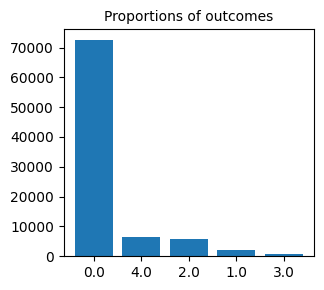

In [37]:
gr.dist_mult_plots(
    df_heart_train,
    cols=[label_col],
		rename_cols_for_title={label_col: 'Proportions of outcomes'},
    figsize=(6, 3),
    ncols=2,
    bar_plot=True,
    fontsize={
        'ax_title': 10,
    },
)

# Raw time series

## Minimal Features preprocessing

(No feature engineering)

In [38]:
# Type of columns
label_col = list(df_heart_train.columns)[-1]
num_features = list(df_heart_train.columns)[:-1]
categorical_features=[]
category_to_drop={}



In [39]:
pn.Column(pn.Row(base.param.add_one_hot_encoded, base.param.stand_features, base.param.test_size))

BokehModel(combine_events=True, render_bundle={'docs_json': {'580fdb01-5653-445a-bba6-757727239f90': {'version…

In [40]:
import py_lib as lib
reload(lib)
import py_lib as lib

In [41]:
x_train_0, x_test_0, y_train_0, y_test_0 = lib.pre_process_ecg(
        df_heart_train,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=True,
				with_lstm_transfo=False,
				for_keras=True,
				n_classes=n_classes,
)

: 

In [ ]:
pd.DataFrame(np.argmax(y_train_0, axis=1)).value_counts()

0
0    57892
4     5182
2     4676
1     1797
3      496
Name: count, dtype: int64

### Working with the class imbalance

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        y_true = tf.cast(y_true, tf.float32)
        
        alpha_t = y_true * alpha + (K.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (K.ones_like(y_true) - y_true) * (1 - y_pred)
        fl = - alpha_t * K.pow((K.ones_like(y_true) - p_t), gamma) * K.log(p_t)
        
        return K.mean(fl)
    return focal_loss_fixed

## Model A: Logistic Regression

### Model Building

In [219]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import Dense,Dropout
from keras.optimizers import  SGD
from keras.optimizers import  RMSprop
from keras.optimizers import Adam
from keras.losses import BinaryFocalCrossentropy
from keras.models import Model
from keras.layers import Input
from torchmetrics.classification import BinaryF1Score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [ ]:
def build_model(
	learning_rate=0.001,
	final_dropout = 0.1,
	clipnorm=0.5,
	use_focal=False,
	use_bidirectional=False,
	use_sgd_opt=False,
	use_rms_opt=False,
	alpha_focal_loss=0.25,
	input_dim=187,
	n_classes=4,
	l1_reg=0.01,
	with_extra_dense_layer=False,
	n_neurons=10,
):
	if use_sgd_opt:
		opt = SGD(learning_rate=learning_rate, clipnorm=clipnorm)
	elif use_rms_opt:
		opt = RMSprop(learning_rate=learning_rate, clipnorm=clipnorm)
	else:
		opt = Adam(learning_rate=learning_rate)


	# Initialize a Sequential model
	# model = Sequential()

	# Add a Dense layer with sigmoid activation for binary classification
	# model.add(Dense(1, activation='sigmoid', input_shape=(input_dim,)))
	inputs = layers.Input(shape=(input_dim,))
	print('added linput!')
	if with_extra_dense_layer:
		x = Dense(n_neurons, activation='relu')(inputs)
		x = (Dropout(final_dropout))(x)
		x = Dense(int(2*n_neurons/3), activation='relu')(x)
		x = Dropout(final_dropout)(x)
		x = Dense(int(n_neurons/3), activation='relu')(x)
		# model.add(Dense(int(n_neurons/3), activation='relu', input_shape=(input_dim,)))
		if l1_reg is not None:
			output = Dense(n_classes, activation='softmax', kernel_regularizer=regularizers.l1(l1_reg))(x)
		else:
			output = Dense(n_classes, activation='softmax')(x)

	else:
		if l1_reg is not None:
			output = Dense(n_classes, activation='softmax', kernel_regularizer=regularizers.l1(l1_reg))(x)
		else:
			output = Dense(n_classes, activation='softmax')(x)

	model = models.Model(inputs, output)

	if use_focal:
		
		model.compile(loss=focal_loss(), optimizer=opt, metrics=['accuracy'])
		# model.compile(loss=BinaryFocalCrossentropy(alpha=alpha_focal_loss), optimizer=opt, metrics=['accuracy'])
	else:
		model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	print(model.summary())
	return model

In [ ]:
model_log_v2 = build_model(
	learning_rate=0.001,
	final_dropout = 0.1,
	clipnorm=0.5,
	use_focal=True,
	use_sgd_opt=False,
	use_rms_opt=False,
	alpha_focal_loss=0.25,
  input_dim=x_train_0.shape[1],
	n_classes=n_classes,
	l1_reg=0.005,
	with_extra_dense_layer=True,
	n_neurons=120,
)

added linput!


Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 187)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 120)            │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 80)             │         9,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 5)              │           205 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,685 (139.39 KB)

 Trainable params: 35,685 (139.39 KB)

 Non-trainable params: 0 (0.00 B)

None


## Training

In [195]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [237]:
# from tensorflow.keras.models import save_model
# model_log_v2.save("model_log_v2.h5")
# model_log_v2.save('model_log_v2.keras')
# print("Saved model to disk")

Saved model to disk


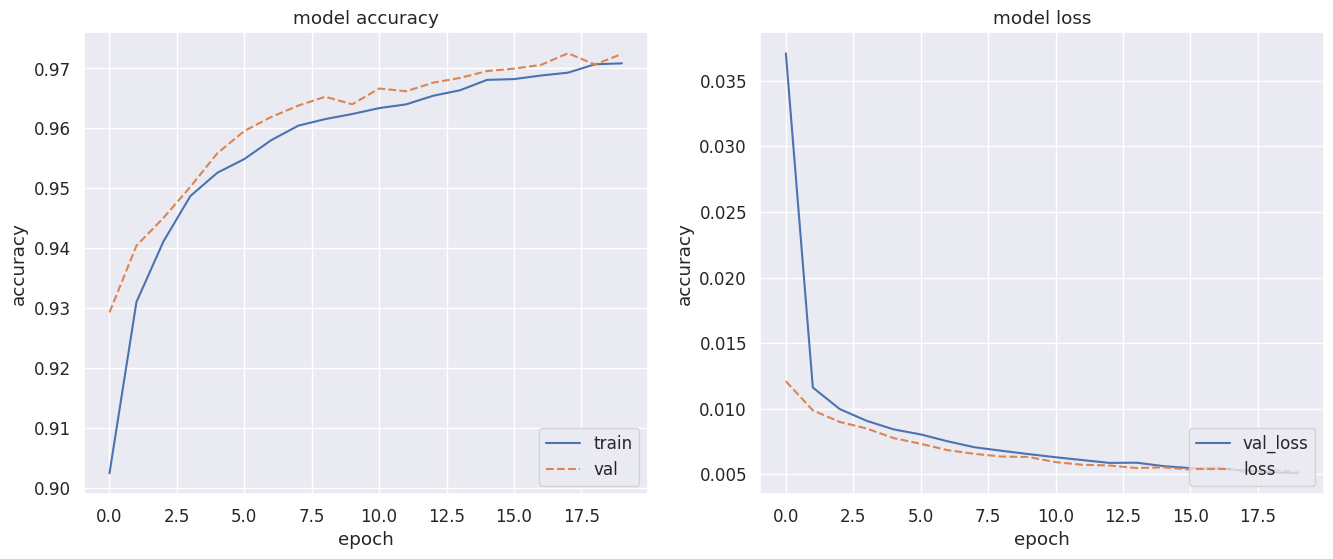

In [198]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

## Evaluation

In [ ]:
from tensorflow.keras.models import load_model

# Load the pre-trained encoder
model_log = load_model('model_log_v2.keras', custom_objects={'focal_loss_fixed': focal_loss})

TypeError: Could not locate function 'focal_loss_fixed'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'focal_loss_fixed', 'registered_name': 'function'}

In [23]:
x_eval, _, y_eval, _, torch_input = lib.pre_process_ecg(
        df_heart_test,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=False,
				with_lstm_transfo=False,
				for_keras=True,
				n_classes=n_classes,
				output_torch_for_eval=True,
)

In [201]:
y_pred_proba = model_log.predict(x_eval)
y_pred_proba_tensor = torch.from_numpy(y_pred_proba)
y_pred_class = np.argmax(y_pred_proba, axis=1)
y_pred_class_df = pd.Series(y_pred_class)
y_pred_class_tensor = torch.from_numpy(y_pred_class)
y_true = np.argmax(y_eval, axis=1)
y_true_tensor = torch.from_numpy(y_true)

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [202]:
y_pred_class_df.value_counts()

0    18425
4     1570
2     1498
1      349
3       50
Name: count, dtype: int64

In [203]:
from sklearn.metrics import f1_score
acc = accuracy_score(y_true, y_pred_class_tensor, normalize = True)  
# bal_acc=balanced_accuracy_score(y_true_tensor,y_pred_class_tensor)
bal_acc=balanced_accuracy_score(y_true,y_pred_class_tensor)
# f1_score = BinaryF1Score()
f1 = f1_score(y_pred_class, y_true, average='macro')
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [204]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,97.2%,75.0%,80.4%


In [205]:
classes_correspondances = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
classes_correspondances_inverted = {0:'N', 1:'S', 2:'V', 3:'F', 4:'Q'}
list_for_graph_labels = []
for i in range(5):
	list_for_graph_labels.append(str(i) + f": '{classes_correspondances_inverted[i]}'")
list_for_graph_labels

["0: 'N'", "1: 'S'", "2: 'V'", "3: 'F'", "4: 'Q'"]

Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

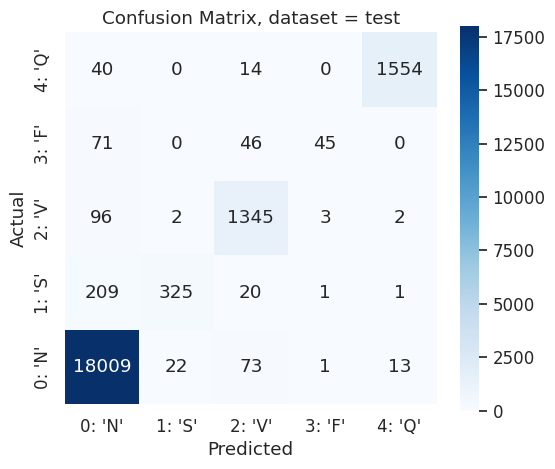

In [206]:
logreg_conf_matrix = confusion_matrix(y_true_tensor, y_pred_class_tensor)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=list_for_graph_labels,
    yticklabels=list_for_graph_labels)
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
# ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

In [207]:
# equivalent to: model.save("model.h5")
from tensorflow.keras.models import save_model
# save_model(model, "model_second_save.h5")
# save model and architecture to single file
model_log.save("model_log_v2.h5")
model_log.save('model_log_v2.keras')
print("Saved model to disk")

Saved model to disk


# Appendix

**Initial version of the model, in Sequential mode**

In [ ]:
def build_model(
	learning_rate=0.001,
	final_dropout = 0.1,
	clipnorm=0.5,
	use_focal=False,
	use_bidirectional=False,
	use_sgd_opt=False,
	use_rms_opt=False,
	alpha_focal_loss=0.25,
	input_dim=187,
	n_classes=4,
	l1_reg=0.01,
	with_extra_dense_layer=False,
	n_neurons=10,
):
	if use_sgd_opt:
		opt = SGD(learning_rate=learning_rate, clipnorm=clipnorm)
	elif use_rms_opt:
		opt = RMSprop(learning_rate=learning_rate, clipnorm=clipnorm)
	else:
		opt = Adam(learning_rate=learning_rate)


	# Initialize a Sequential model
	model = Sequential()

	# Add a Dense layer with sigmoid activation for binary classification
	# model.add(Dense(1, activation='sigmoid', input_shape=(input_dim,)))
	if with_extra_dense_layer:
		model.add(Dense(n_neurons, activation='relu', input_shape=(input_dim,)))
		model.add(Dropout(final_dropout))
		model.add(Dense(int(2*n_neurons/3), activation='relu', input_shape=(input_dim,)))
		model.add(Dropout(final_dropout))
		model.add(Dense(int(n_neurons/3), activation='relu', input_shape=(input_dim,)))
		if l1_reg is not None:
			model.add(Dense(n_classes, activation='softmax', kernel_regularizer=regularizers.l1(l1_reg)))
		else:
			model.add(Dense(n_classes, activation='softmax'))
			

	else:
		if l1_reg is not None:
			model.add(Dense(n_classes, activation='softmax', input_shape=(input_dim,), kernel_regularizer=regularizers.l1(l1_reg)))
		else:
			model.add(Dense(n_classes, activation='softmax', input_shape=(input_dim,)))

	if use_focal:
		
		model.compile(loss=focal_loss(), optimizer=opt, metrics=['accuracy'])
		# model.compile(loss=BinaryFocalCrossentropy(alpha=alpha_focal_loss), optimizer=opt, metrics=['accuracy'])
	else:
		model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	print(model.summary())
	return model